# Q-Learning for Cartpole

The following is an implementation of Q-Learning and double Q-Learning to solve a discretized version of the cartpole environment.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import KBinsDiscretizer
from time import sleep

In [2]:
np.random.seed(0)

### Parameters

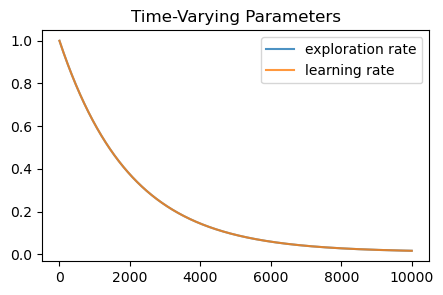

In [3]:
# Parameters
num_episodes = 10000
max_steps = 200 # maximum number of steps per episode
gamma = 0.99 # discount rate

# Time-Varying Parameters
def epsilon(episode, max=1, min=0.01, decay_rate=0.0005):
    """
    Returns the exploration rate given the episode number
    """
    return min + (max-min) * np.exp(-decay_rate*episode)

def alpha(episode, max=1, min=0.01, decay_rate=0.0005):
    """
    Returns the learning rate given the episode number
    """
    return min + (max-min) * np.exp(-decay_rate*episode)

plt.figure(figsize=(5, 3));
plt.title('Time-Varying Parameters');
plt.plot([epsilon(i) for i in range(num_episodes)], label='exploration rate', alpha=0.8);
plt.plot([alpha(i) for i in range(num_episodes)], label='learning rate', alpha=0.8);
plt.legend();

### State Discretizer

In [4]:
env = gym.make('CartPole-v1')

# see https://www.gymlibrary.dev/environments/classic_control/cart_pole/ for more details
print('Observation Space \n', env.observation_space) # position, velocity, angle, angular velocity
print('Action Space \n', env.action_space)

num_actions = env.action_space.n

Observation Space 
 Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space 
 Discrete(2)


In [5]:
n_bins = (6, 12)
lower_bounds = [env.observation_space.low[2], -math.radians(50)]
upper_bounds = [env.observation_space.high[2], math.radians(50)]
# see # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer
state_discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform').fit([lower_bounds, upper_bounds])

def discretizer(position, velocity, angle, angular_velocity):
    """
    Convert continous state into a discrete state. 
    Ignores position and velocity.
    """
    return tuple(map(int, state_discretizer.transform([[angle, angular_velocity]])[0])) # maps to integers and converts into 1D tuple
    

In [6]:
sample_state = env.reset() # starting state
print('Sample state:', sample_state)

discretized_sample_state = discretizer(*sample_state)
print('Discretized Sample State:', discretized_sample_state)

Sample state: [-0.03070453 -0.02347693  0.04226357  0.0337386 ]
Discretized Sample State: (3, 6)


### One Iteration

In [7]:
all_rewards = []
Q = np.zeros((*n_bins, num_actions)) # initialize Q[s][a] arbitrarily (note this is a 3D table)

for episode in range(num_episodes):
    
    episode_reward = 0 # total reward for the current episode
    state = env.reset()
    state = discretizer(*state)
    
    for step in range(max_steps):
        
        if np.random.uniform(0, 1) < epsilon(episode):
            action = env.action_space.sample() # random action
        else:
            action = np.argmax(Q[state][:]) # greedy action
        
        next_state, reward, done, info = env.step(action)
        next_state = discretizer(*next_state)
        
        Q[state][action] = Q[state][action] + alpha(episode)*(reward + gamma*np.max(Q[next_state][:]) - Q[state][action])
        
        state = next_state
        episode_reward += reward
        
        if episode%100==0:
            env.render()
        
        if done:
            break
        
    all_rewards.append(episode_reward)

env.close()

KeyboardInterrupt: 

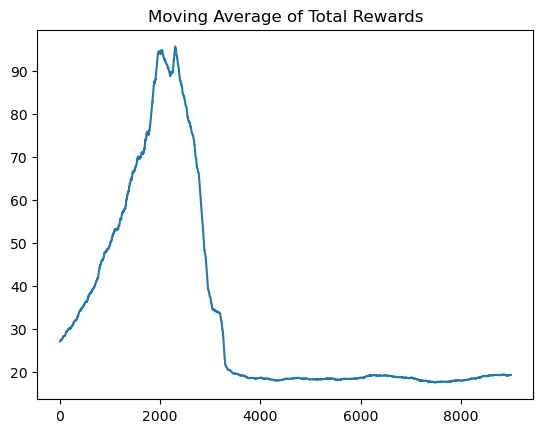

In [ ]:
def moving_average(array, n=100):
    """
    Returns the moving average of an array over a window of size n.
    """
    return np.convolve(array, np.ones(n), 'valid')/n

plt.plot(moving_average(all_rewards, 1000));
plt.title('Moving Average of Total Rewards');

### Multiple Iterations

In [ ]:
num_iterations = 10
all_iterations = []

for iteration in range(num_iterations):

    all_rewards = []
    Q = np.zeros((*n_bins, num_actions)) # initialize Q[s][a] arbitrarily 
    # Note: this is actualy a 3D table since the state is parametized by two variables, s = (s1, s2)

    for episode in range(num_episodes):
        
        episode_reward = 0 # total reward for the current episode
        state = env.reset()
        state = discretizer(*state)
        
        for step in range(max_steps):
            
            if np.random.uniform(0, 1) < epsilon(episode):
                action = env.action_space.sample() # random action
            else:
                action = np.argmax(Q[state][:]) # greedy action
            
            next_state, reward, done, info = env.step(action)
            next_state = discretizer(*next_state)
            
            Q[state][action] = Q[state][action] + alpha(episode)*(reward + gamma*np.max(Q[next_state][:]) - Q[state][action])
            
            state = next_state
            episode_reward += reward
            
            if episode%100==0:
                env.render()
            
            if done:
                break
            
        all_rewards.append(episode_reward)
    
    env.close()
    all_iterations.append(all_rewards)
    print(f'Iteration {iteration} done 👍')

KeyboardInterrupt: 

In [ ]:
all_iterations = np.array(all_iterations)

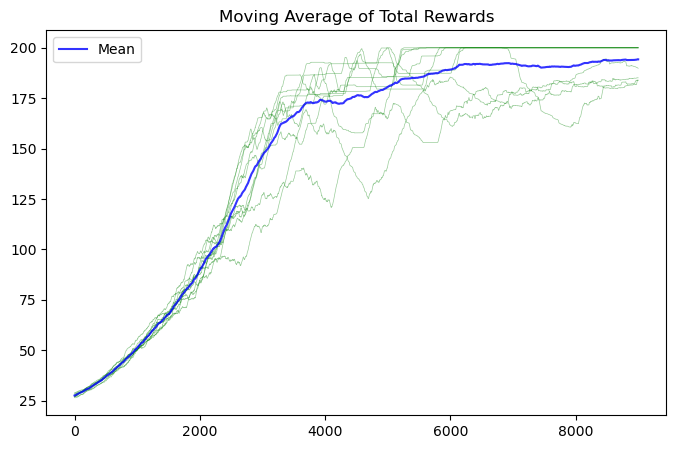

In [ ]:
window = 1000

plt.figure(figsize=(8, 5));
plt.title('Moving Average of Total Rewards');
for i in range(num_iterations):
    plt.plot(moving_average(all_iterations[i], window), alpha=0.4, color='green', lw=0.5);
plt.plot(moving_average(all_iterations.mean(axis=0), window), alpha=0.8, color='blue', label='Mean');
plt.legend();